<a href="https://colab.research.google.com/github/parkyw2/parkyw2/blob/main/%EA%B8%B0%EC%9E%AC%ED%92%88_%EC%88%98%EC%84%A0%EB%B9%84_%EA%B3%B5%EC%9E%A5%EB%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/회사 데이터

/content/drive/My Drive/회사 데이터


In [4]:
df = pd.read_csv('수선비_기재품_plant_20220308.csv')

In [5]:
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180,total
1086,2021-12-22,11015014,849749,0,4264120,12978,6244952,7855598,1986058,32228469
1087,2021-12-23,34990463,355232,0,7297627,0,5149153,5067257,6695754,59555486
1088,2021-12-24,5590498,6650433,0,1298763,0,2368324,3943195,0,19851213
1089,2021-12-25,1217584,0,0,219539,0,1212904,286747,0,2936774
1090,2021-12-26,50856,0,0,188500,0,0,106200,0,345556
1091,2021-12-27,8170353,5692078,0,4842059,0,5078067,892793,1207522,25882872
1092,2021-12-28,10194416,6245477,0,17376007,0,25430223,19868103,7006737,86120963
1093,2021-12-29,5964013,2509500,0,1770660,0,12632018,11809706,4455711,39141608
1094,2021-12-30,8877249,5982917,0,2974314,875123,18953435,13077730,10129300,60870068
1095,2021-12-31,8349826,1085740,0,8798434,0,14436548,7612966,0,40283514


In [6]:
df2 = df.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]

In [7]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('수선비_기재품_20220321').sheet1

rows = worksheet.get_all_values()
print(rows)

df_new = pd.DataFrame.from_records(rows)
df_new = df_new[1:]
df_new.columns = ["date", "1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180", "total"]
df_new = df_new.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]
df_new = df_new.fillna(0)
df_new = df_new.astype({'1110':'int','1120':'int','1130':'int','1140':'int','1150':'int','1160':'int','1170':'int','1180':'int'})

[['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180', 'total'], ['2022-01-01', '0', '3283239', '0', '0', '0', '771166', '567660', '0', '4622065'], ['2022-01-02', '0', '0', '0', '0', '0', '199140', '0', '0', '199140'], ['2022-01-03', '2191422', '2413550', '0', '3048627', '0', '1333327', '430800', '9660', '9427386'], ['2022-01-04', '2027249', '2575771', '0', '1268000', '0', '4697450', '1807209', '43202', '12418881'], ['2022-01-05', '5694281', '6705740', '0', '3175188', '0', '17233921', '3416145', '891957', '37117232'], ['2022-01-06', '772272', '690580', '0', '2305195', '0', '2952847', '2296979', '158856', '9176729'], ['2022-01-07', '4995505', '530080', '0', '608999', '0', '6708387', '2663503', '371415', '15877889'], ['2022-01-08', '787193', '1172694', '0', '10400', '0', '256669', '1620', '0', '2228576'], ['2022-01-09', '4061888', '0', '0', '0', '0', '4624', '0', '0', '4066512'], ['2022-01-10', '7614602', '472555', '0', '3594835', '0', '1912836', '1534314', '0', '15129

In [8]:
df2 = pd.concat([df2,df_new], axis = 0)
df2

,date,1110,1120,1130,1140,1150,1160,1170,1180
0,2019-01-01,266140,0,0,2513620,0,36574016,413605,0
1,2019-01-02,5427237,331000,67800,318517,0,1375176,376392,0
2,2019-01-03,1673044,9277700,341581,616600,0,2264785,3091350,213875
3,2019-01-04,1282980,815905,0,481662,0,11974295,1121545,147575
4,2019-01-05,6764128,153320,0,695305,0,3126420,22642,245600
...,...,...,...,...,...,...,...,...,...
76,2022-03-17,2261361,2705631,0,2742373,0,12958337,3162070,0
77,2022-03-18,7965847,866227,0,290718,0,5446555,3058456,503979
78,2022-03-19,4129752,0,0,0,0,304800,744480,25500
79,2022-03-20,47906,0,0,0,0,1415799,0,0


In [9]:
df_date = df2['date']
df2 = df2[["1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180"]]
df2[df2 < 0] = 0
df = pd.concat([df_date, df2], axis=1)
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180
71,2022-03-12,1132054,20751390,0,0,0,5688579,3543797,1520
72,2022-03-13,589255,32730,0,0,0,192158,1227150,0
73,2022-03-14,3644499,6579282,0,773700,0,1438837,2045940,206200
74,2022-03-15,10436363,2873918,0,6655316,0,2128319,23268055,7487
75,2022-03-16,2745896,18525237,0,1872809,0,6860336,12743113,1452360
76,2022-03-17,2261361,2705631,0,2742373,0,12958337,3162070,0
77,2022-03-18,7965847,866227,0,290718,0,5446555,3058456,503979
78,2022-03-19,4129752,0,0,0,0,304800,744480,25500
79,2022-03-20,47906,0,0,0,0,1415799,0,0
80,2022-03-21,7787108,479300,0,774462,0,616304,315279,0


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [11]:
from datetime import datetime

#안양
df_1110 = df[['date','1110']]
df_1110['ds'] = pd.to_datetime(df['date'])
df_1110['y'] = df_1110['1110']
df_1110 = df_1110.loc[:,['ds', 'y']]
df_1110['ds'] = pd.to_datetime(df_1110['ds'])
df_1110 = df_1110[df_1110['ds'].dt.dayofweek < 5]
df_1110['date_index'] = df_1110['ds']
df_1110 = df_1110.set_index('date_index')
df_1110['cap'] = 30000000
df_1110['floor'] = 0
df_1110 = df_1110[datetime(2019, 1, 1):datetime(2022, 3, 21)]

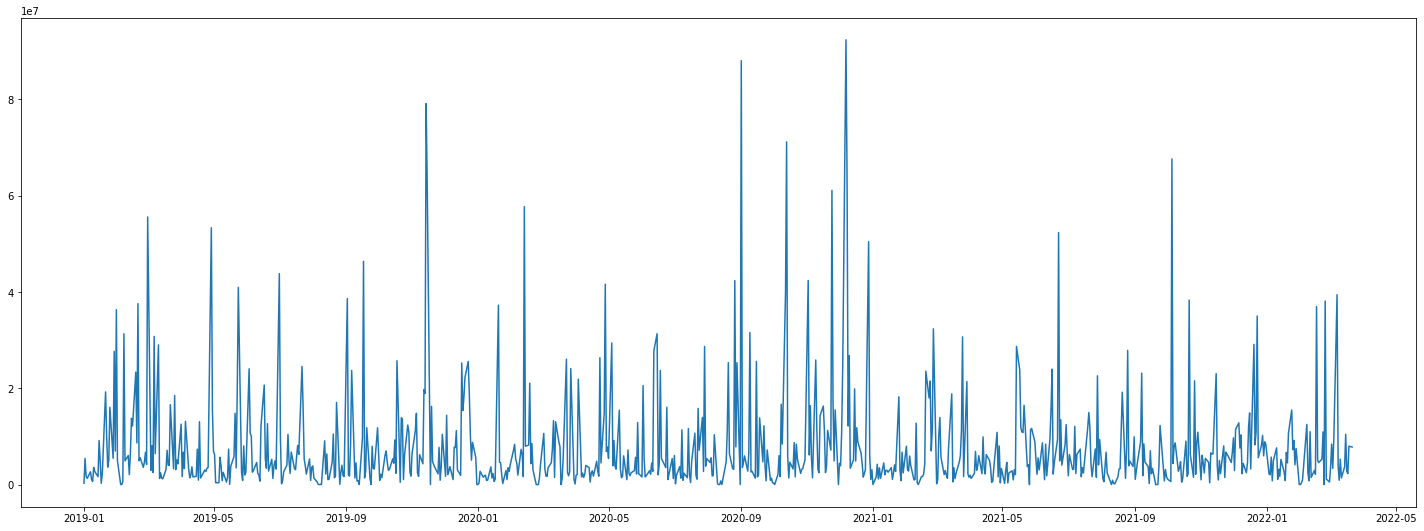

In [12]:
plt.figure(figsize = (25, 9))
plt.plot(df_1110.index,df_1110.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [13]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1110)

future = m.make_future_dataframe(periods=10)    # periods 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 50000000
future['floor'] = 0

forecast=m.predict(future)
preds= forecast['yhat'][:-8]     # 숫자 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,cap,floor
843,2022-03-25,50000000,0
846,2022-03-28,50000000,0
847,2022-03-29,50000000,0
848,2022-03-30,50000000,0
849,2022-03-31,50000000,0


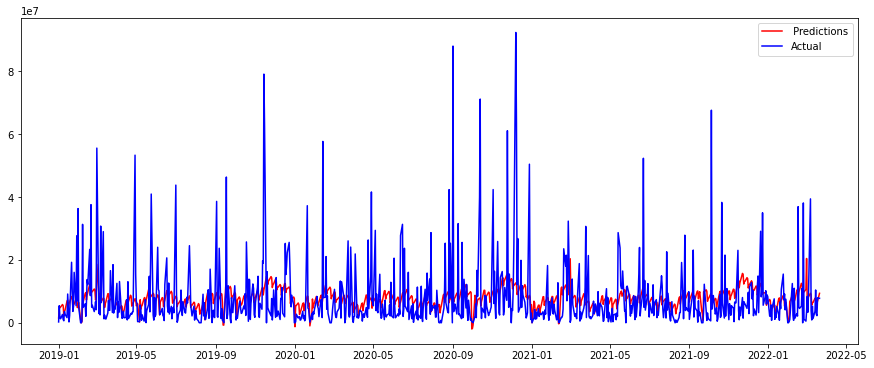

In [15]:
plt.figure(figsize=(15,6))
plt.plot(df_1110.index,preds,color='red',label=' Predictions')
plt.plot(df_1110.index,df_1110.y,color='blue',label='Actual')
plt.legend()
plt.show()

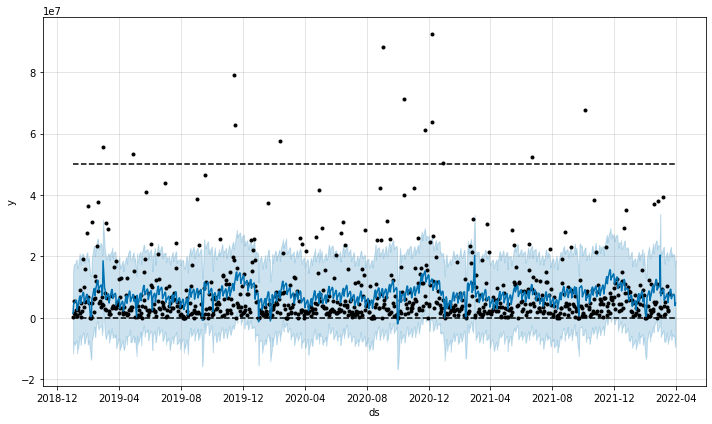

In [16]:
fig = m.plot(m.predict(future))

In [17]:
r2 = round(r2_score(df_1110["y"], preds), 3)
mse = round(mean_squared_error(df_1110["y"], preds), 3)
mae = round(mean_absolute_error(df_1110["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.067
MSE:  108232550797896.34
MAE:  6213510.686


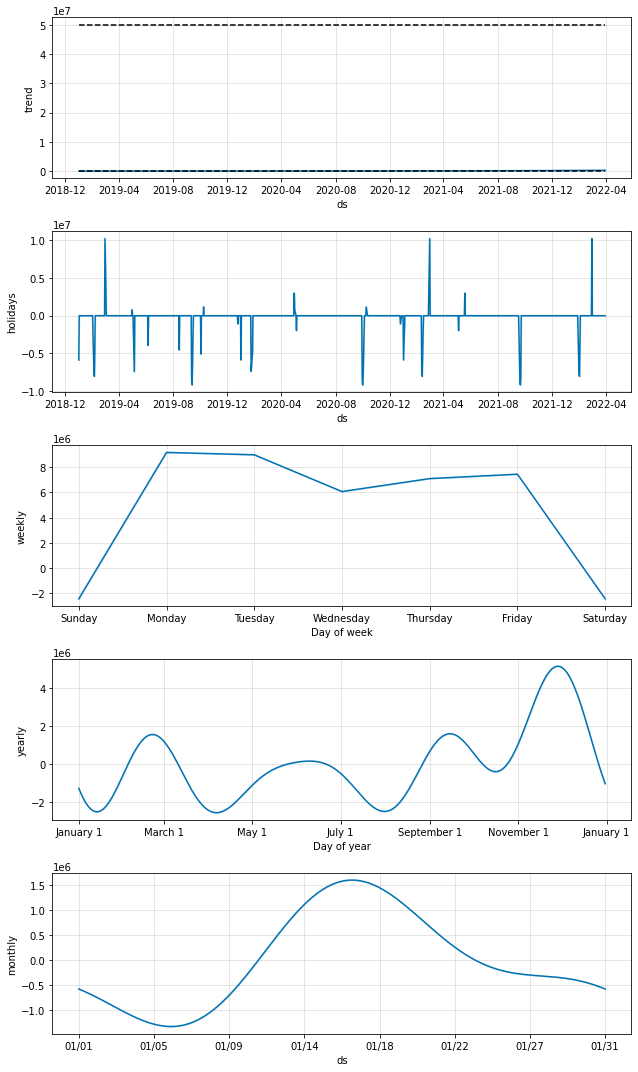

In [18]:
fig = m.plot_components(forecast)

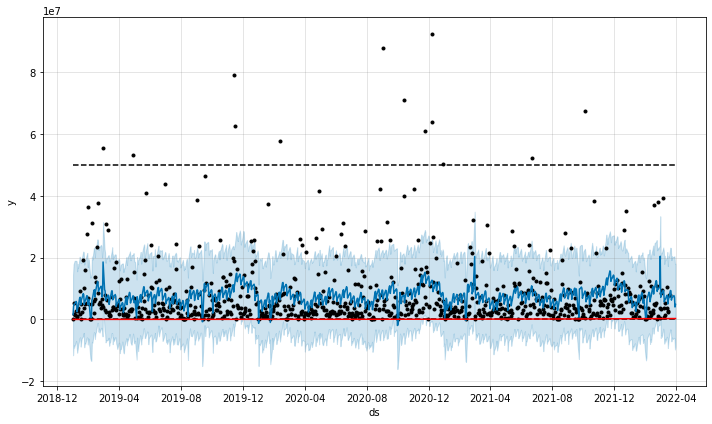

In [19]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [20]:
  pd.options.display.float_format = '{:,.0f}'.format

In [21]:
final_1110 = forecast[['ds', 'yhat']]
final_1110['yhat_1110'] = final_1110['yhat']
final_1110 = final_1110[['ds', 'yhat_1110']]
final_1110.tail()

,ds,yhat_1110
843,2022-03-25,"7,134,771"
844,2022-03-28,"7,734,169"
845,2022-03-29,"7,205,943"
846,2022-03-30,"4,017,256"
847,2022-03-31,"4,837,463"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [25]:
#Ansung

df_1120 = df[['date','1120']]
df_1120['ds'] = pd.to_datetime(df_1120['date'])
df_1120['y'] = df_1120['1120']
df_1120 = df_1120.loc[:,['ds', 'y']]
df_1120['ds'] = pd.to_datetime(df_1120['ds'])
df_1120 = df_1120[df_1120['ds'].dt.dayofweek < 5]
df_1120['date_index'] = df_1120['ds']
df_1120 = df_1120.set_index('date_index')
df_1120['cap'] = 30000000
df_1120['floor'] = 0
df_1120 = df_1120[datetime(2019, 1, 1):datetime(2022, 3, 21)]

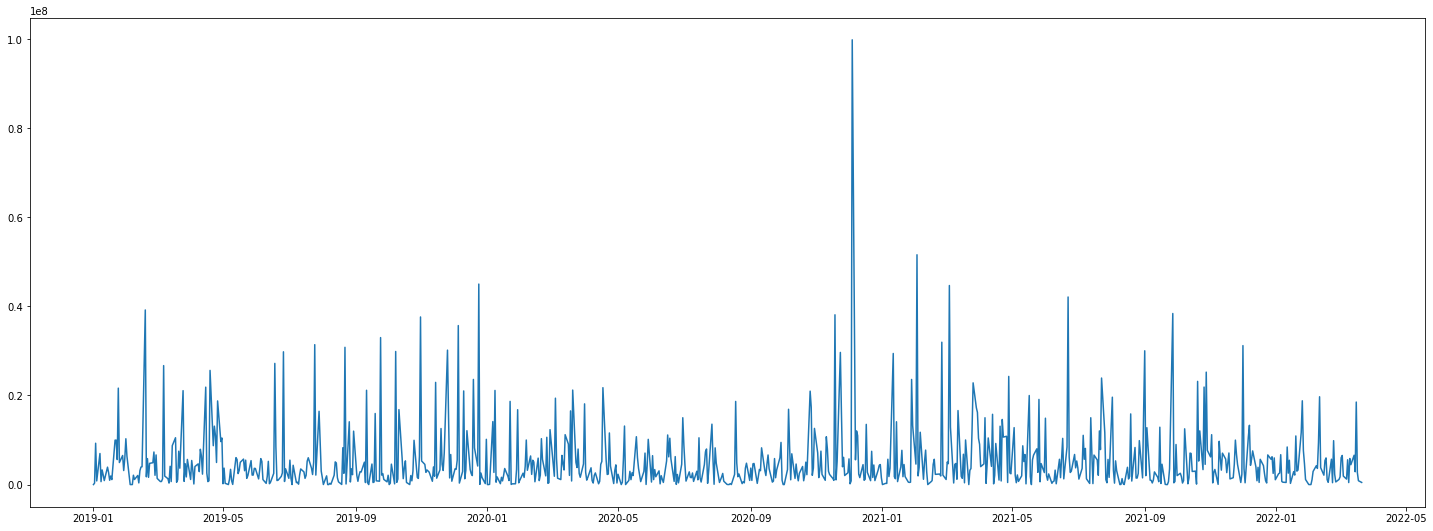

In [26]:
plt.figure(figsize = (25, 9))
plt.plot(df_1120.index,df_1120.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [28]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1120)

future = m.make_future_dataframe(periods=10)             # periods를 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 35000000
future['floor'] = 0
forecast=m.predict(future)
preds= forecast['yhat'][:-8]                  # 숫자를 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


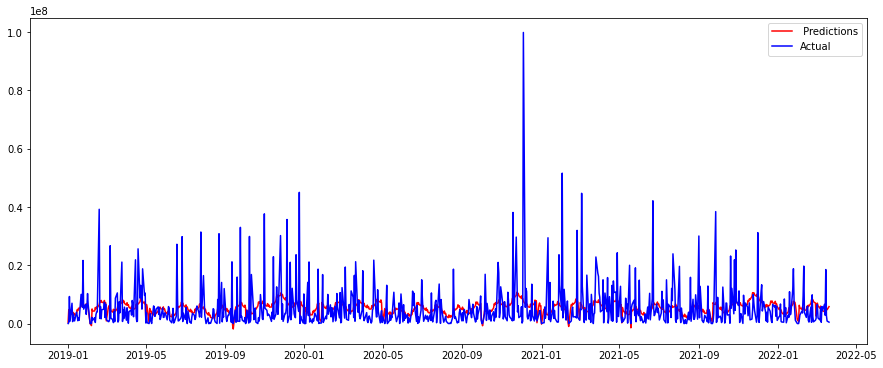

In [29]:
plt.figure(figsize=(15,6))
plt.plot(df_1120.index,preds,color='red',label=' Predictions')
plt.plot(df_1120.index,df_1120.y,color='blue',label='Actual')
plt.legend()
plt.show()

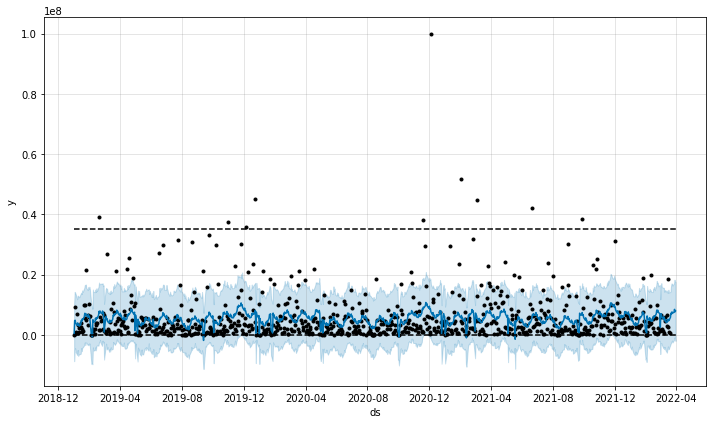

In [30]:
fig = m.plot(m.predict(future))

In [31]:
r2 = round(r2_score(df_1120["y"], preds), 3)
mse = round(mean_squared_error(df_1120["y"], preds), 3)
mae = round(mean_absolute_error(df_1120["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.061
MSE:  55391050664001.39
MAE:  4542627.262


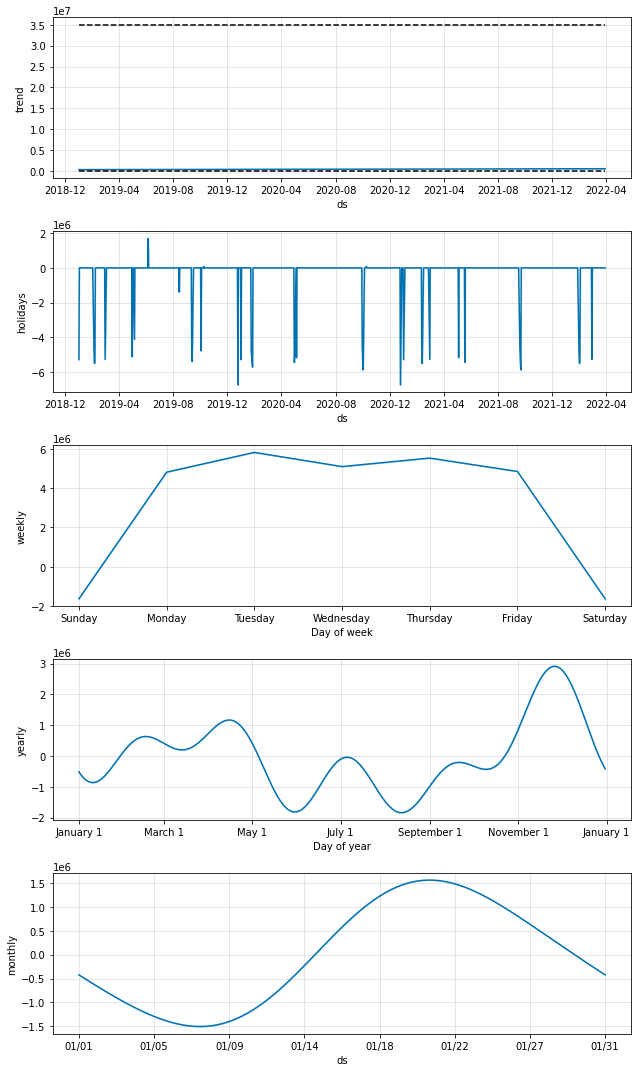

In [32]:
fig = m.plot_components(forecast)

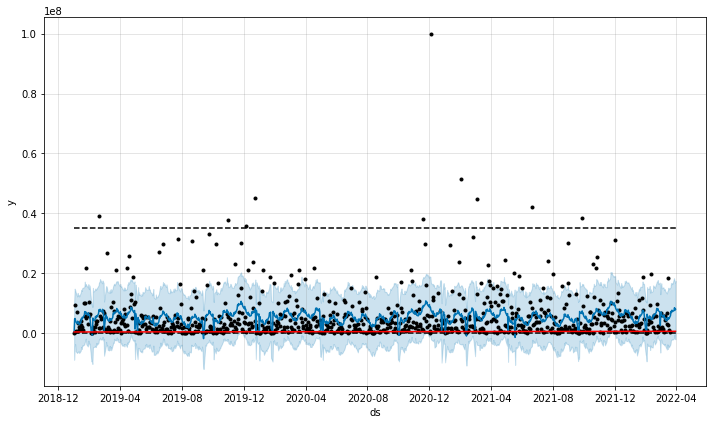

In [33]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [34]:
final_1120 = forecast[['ds', 'yhat']]
final_1120['yhat_1120'] = final_1120['yhat']
final_1120 = final_1120[['ds', 'yhat_1120']]
final_1120.tail()

,ds,yhat_1120
843,2022-03-25,"7,205,403"
844,2022-03-28,"7,494,683"
845,2022-03-29,"8,461,330"
846,2022-03-30,"7,642,883"
847,2022-03-31,"7,933,151"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [35]:
#Asan

df_1140 = df[['date','1140']]
df_1140['ds'] = pd.to_datetime(df_1140['date'])
df_1140['y'] = df_1140['1140']
df_1140 = df_1140.loc[:,['ds', 'y']]

df_1140['ds'] = pd.to_datetime(df_1140['ds'])
df_1140 = df_1140[df_1140['ds'].dt.dayofweek < 5]
df_1140['date_index'] = df_1140['ds']
df_1140 = df_1140.set_index('date_index')
df_1140['cap'] = 30000000
df_1140['floor'] = 0

df_1140 = df_1140[datetime(2019, 1, 1):datetime(2022, 3, 21)]

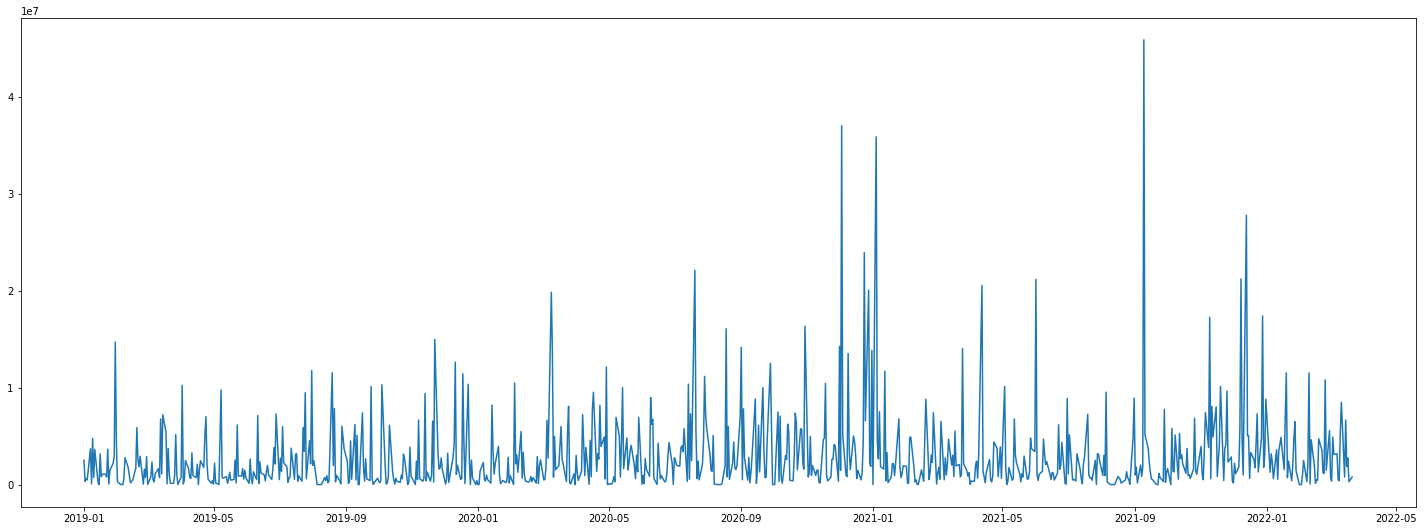

In [36]:
plt.figure(figsize = (25, 9))
plt.plot(df_1140.index,df_1140.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [37]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1140)

future = m.make_future_dataframe(periods=10)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


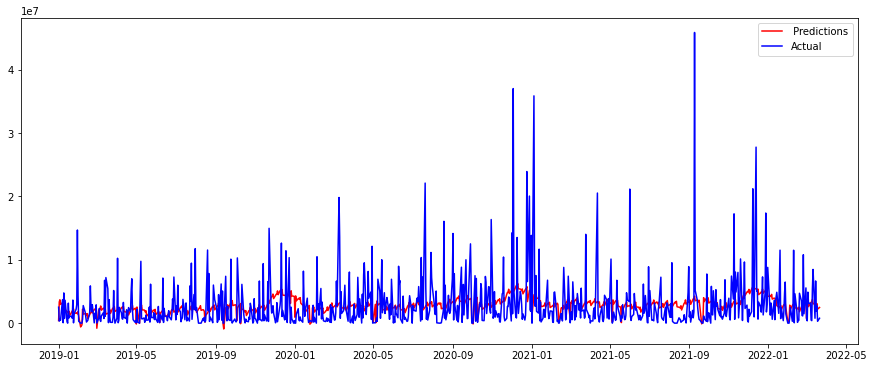

In [38]:
plt.figure(figsize=(15,6))
plt.plot(df_1140.index,preds,color='red',label=' Predictions')
plt.plot(df_1140.index,df_1140.y,color='blue',label='Actual')
plt.legend()
plt.show()

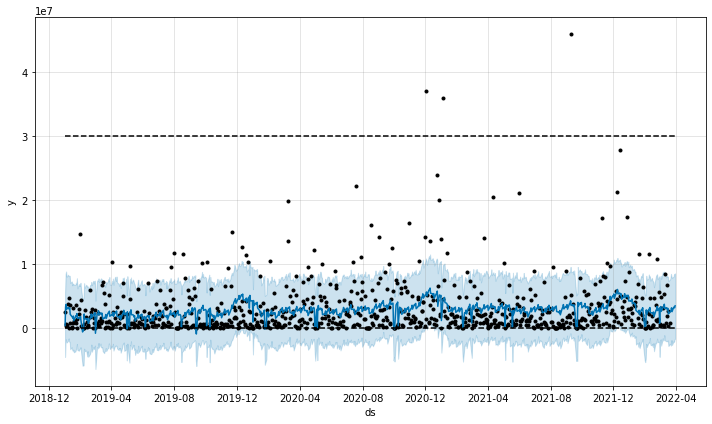

In [39]:
fig = m.plot(m.predict(future))

In [40]:
r2 = round(r2_score(df_1140["y"], preds), 3)
mse = round(mean_squared_error(df_1140["y"], preds), 3)
mae = round(mean_absolute_error(df_1140["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.072
MSE:  16100478583030.805
MAE:  2477009.236


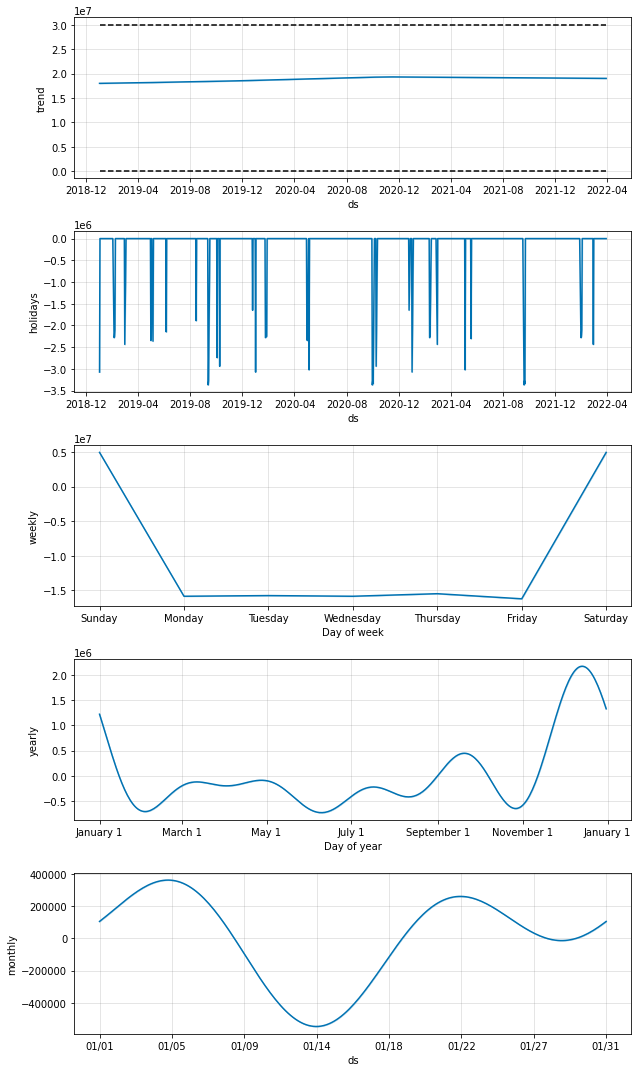

In [41]:
fig = m.plot_components(forecast)

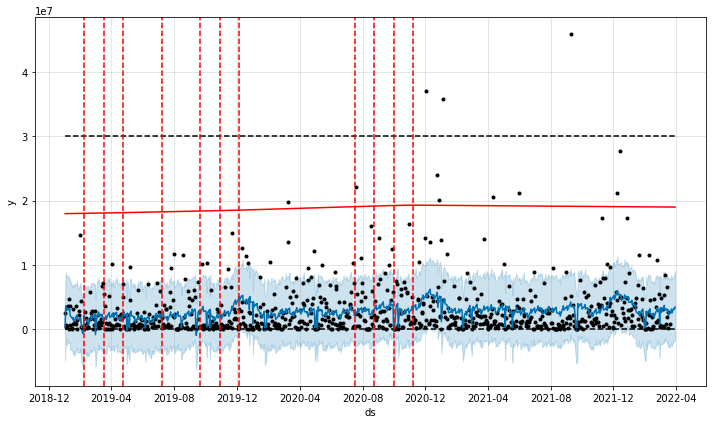

In [42]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [44]:
final_1140 = forecast[['ds', 'yhat']]
final_1140['yhat_1140'] = final_1140['yhat']
final_1140 = final_1140[['ds', 'yhat_1140']]
final_1140.tail()

,ds,yhat_1140
843,2022-03-25,"2,564,355"
844,2022-03-28,"3,199,071"
845,2022-03-29,"3,301,292"
846,2022-03-30,"3,171,552"
847,2022-03-31,"3,480,997"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [45]:
#Poseung

df_1150 = df[['date','1150']]
df_1150['ds'] = pd.to_datetime(df_1150['date'])
df_1150['y'] = df_1150['1150']
df_1150 = df_1150.loc[:,['ds', 'y']]

df_1150['ds'] = pd.to_datetime(df_1150['ds'])
df_1150 = df_1150[df_1150['ds'].dt.dayofweek < 5]
df_1150['date_index'] = df_1150['ds']
df_1150 = df_1150.set_index('date_index')
df_1150['cap'] = 30000000
df_1150['floor'] = 0

df_1150 = df_1150[datetime(2019, 1, 1):datetime(2022, 3, 21)]

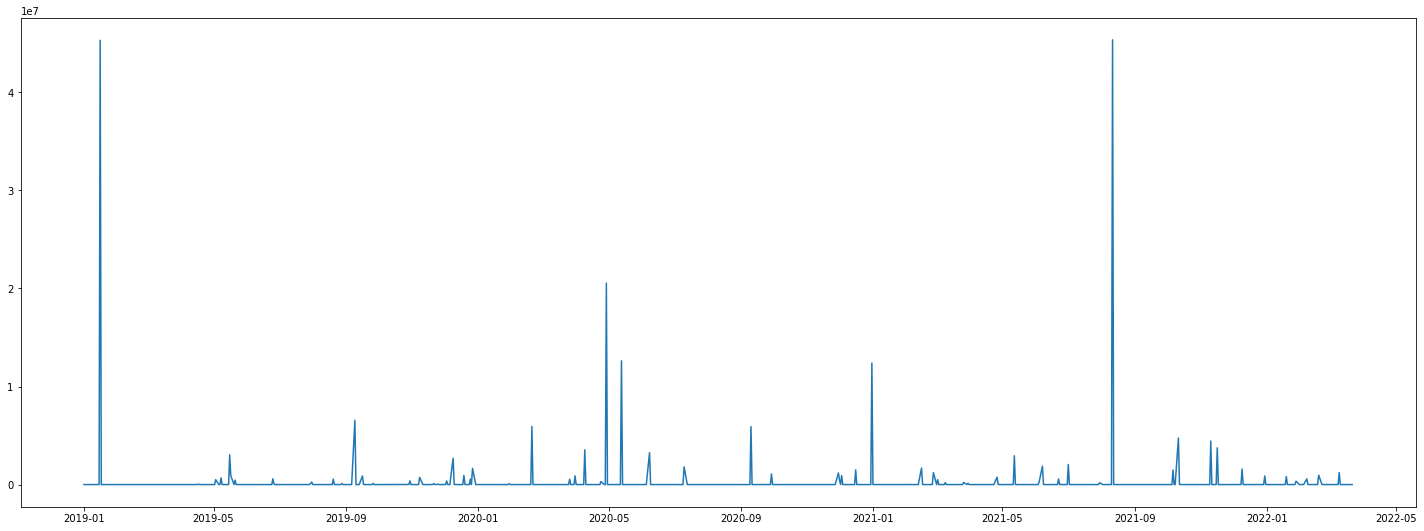

In [46]:
plt.figure(figsize = (25, 9))
plt.plot(df_1150.index,df_1150.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [47]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1150)

future = m.make_future_dataframe(periods=10)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


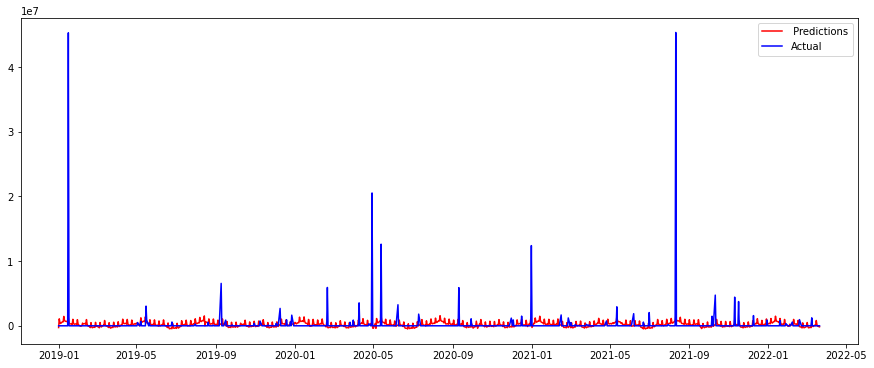

In [48]:
plt.figure(figsize=(15,6))
plt.plot(df_1150.index,preds,color='red',label=' Predictions')
plt.plot(df_1150.index,df_1150.y,color='blue',label='Actual')
plt.legend()
plt.show()

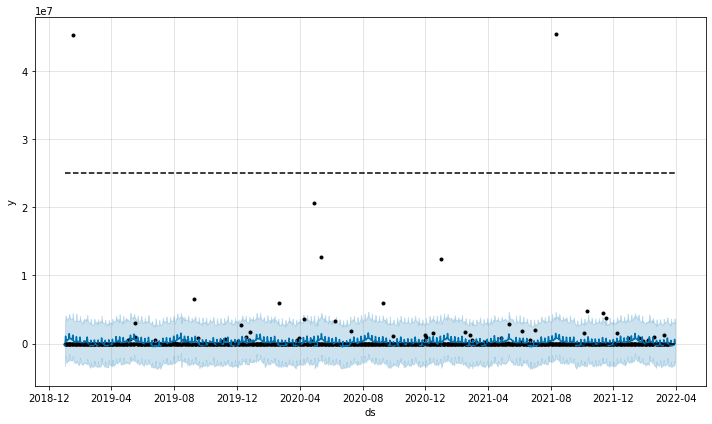

In [49]:
fig = m.plot(m.predict(future))

In [50]:
r2 = round(r2_score(df_1150["y"], preds), 3)
mse = round(mean_squared_error(df_1150["y"], preds), 3)
mae = round(mean_absolute_error(df_1150["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.027
MSE:  5846000299181.438
MAE:  579274.623


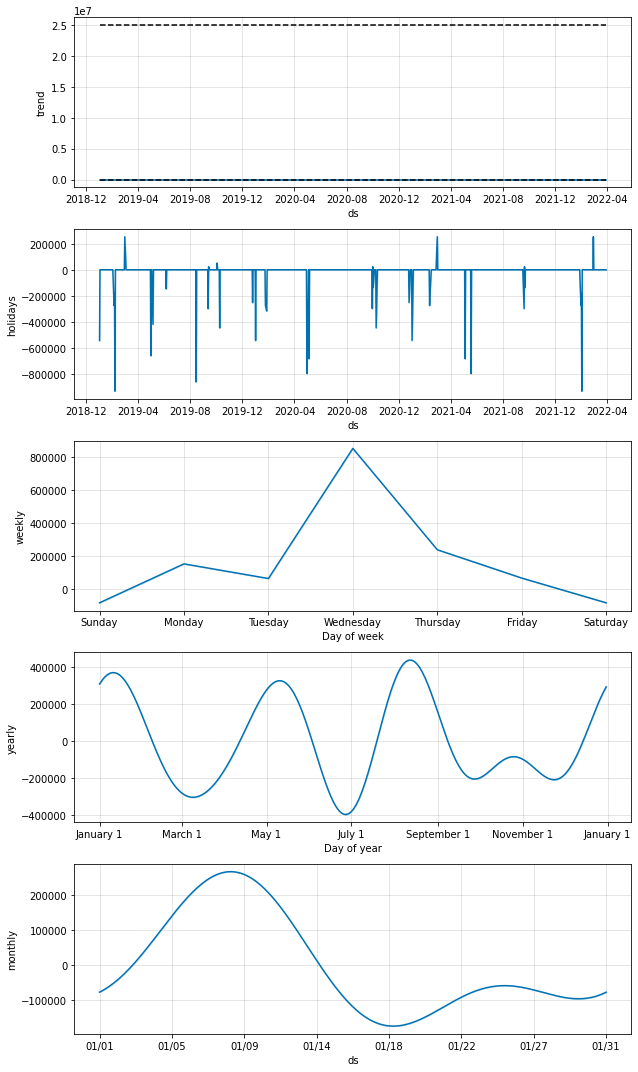

In [51]:
fig = m.plot_components(forecast)

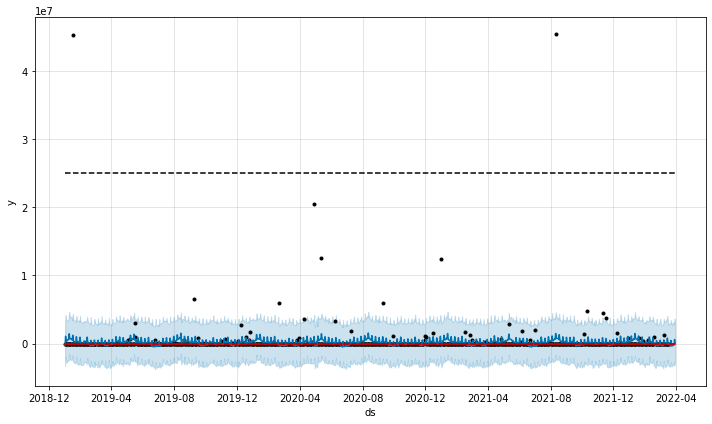

In [52]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [54]:
final_1150 = forecast[['ds', 'yhat']]
final_1150['yhat_1150'] = final_1150['yhat']
final_1150 = final_1150[['ds', 'yhat_1150']]
final_1150.tail()

,ds,yhat_1150
843,2022-03-25,"-338,305"
844,2022-03-28,"-160,874"
845,2022-03-29,"-214,207"
846,2022-03-30,"607,528"
847,2022-03-31,"11,040"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [ ]:
#GUMI
df_1160 = df[['date','1160']]
df_1160['ds'] = pd.to_datetime(df_1160['date'])
df_1160['y'] = df_1160['1160']
df_1160 = df_1160.loc[:,['ds', 'y']]

df_1160['ds'] = pd.to_datetime(df_1160['ds'])
df_1160 = df_1160[df_1160['ds'].dt.dayofweek < 5]
df_1160['date_index'] = df_1160['ds']
df_1160 = df_1160.set_index('date_index')
df_1160['cap'] = 30000000
df_1160['floor'] = 0

df_1160 = df_1160[datetime(2019, 1, 1):datetime(2022, 3, 21)]

,ds,y
0,2019-01-01,36574016
1,2019-01-02,1375176
2,2019-01-03,2264785
3,2019-01-04,11974295
4,2019-01-05,3126420


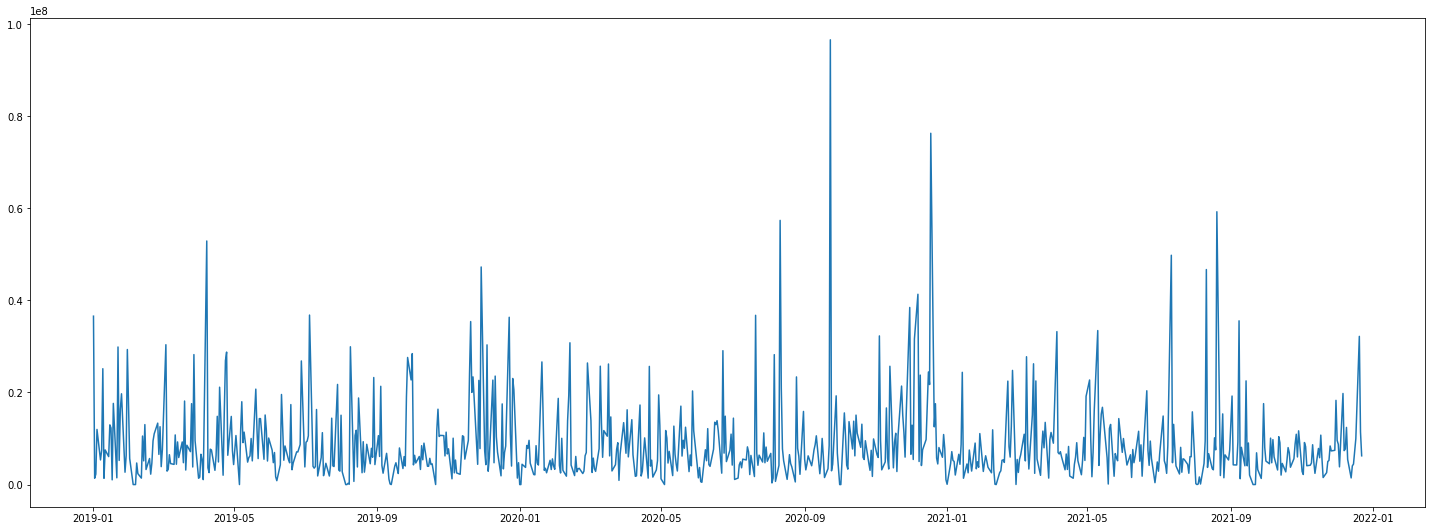

In [ ]:
plt.figure(figsize = (25, 9))
plt.plot(df_1160.index,df_1160.y)
plt.show()

In [ ]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1160)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"26,676,027",30000000,0,"-758,875","21,192,594","26,676,027","26,676,027",0,0,...,"-20,774,803","-20,774,803","-20,774,803","4,277,945","4,277,945","4,277,945",0,0,0,"9,988,566"
775,2021-12-21,"26,659,885",30000000,0,"-269,565","22,318,096","26,659,885","26,659,885",0,0,...,"-20,122,204","-20,122,204","-20,122,204","4,084,733","4,084,733","4,084,733",0,0,0,"10,651,072"
776,2021-12-22,"26,643,674",30000000,0,"945,345","23,004,930","26,643,674","26,643,674",0,0,...,"-19,409,919","-19,409,919","-19,409,919","3,879,086","3,879,086","3,879,086",0,0,0,"11,416,301"
777,2021-12-23,"26,627,395",30000000,0,"-1,062,325","20,714,449","26,627,395","26,627,395",0,0,...,"-21,218,408","-21,218,408","-21,218,408","3,661,979","3,661,979","3,661,979",0,0,0,"9,671,513"
778,2021-12-24,"26,611,047",30000000,0,"-719,682","22,657,334","26,611,047","26,611,047",0,0,...,"-20,073,560","-20,073,560","-20,073,560","3,434,442","3,434,442","3,434,442",0,0,0,"10,851,778"
779,2021-12-27,"26,561,587",30000000,0,"-533,269","21,319,705","26,561,587","26,561,587",0,0,...,"-20,774,803","-20,774,803","-20,774,803","2,700,221","2,700,221","2,700,221",0,0,0,"9,727,845"
780,2021-12-28,"26,544,961",30000000,0,"-1,308,881","21,826,914","26,544,961","26,544,961",0,0,...,"-20,122,204","-20,122,204","-20,122,204","2,442,116","2,442,116","2,442,116",0,0,0,"9,994,686"
781,2021-12-29,"26,528,265",30000000,0,"-853,331","21,923,353","26,528,265","26,528,265",0,0,...,"-19,409,919","-19,409,919","-19,409,919","2,179,313","2,179,313","2,179,313",0,0,0,"10,203,052"
782,2021-12-30,"26,511,499",30000000,0,"-2,743,736","18,155,084","26,511,499","26,511,499",0,0,...,"-21,218,408","-21,218,408","-21,218,408","1,913,032","1,913,032","1,913,032",0,0,0,"7,799,218"
783,2021-12-31,"26,494,663",30000000,0,"-3,604,528","20,168,602","26,494,663","26,494,663",0,0,...,"-20,073,560","-20,073,560","-20,073,560","1,644,496","1,644,496","1,644,496",0,0,0,"8,296,057"


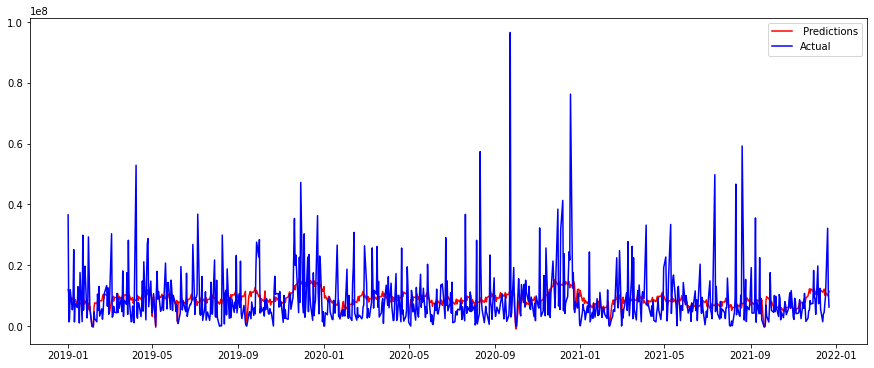

In [ ]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1160.index,preds,color='red',label=' Predictions')
plt.plot(df_1160.index,df_1160.y,color='blue',label='Actual')
plt.legend()
plt.show()

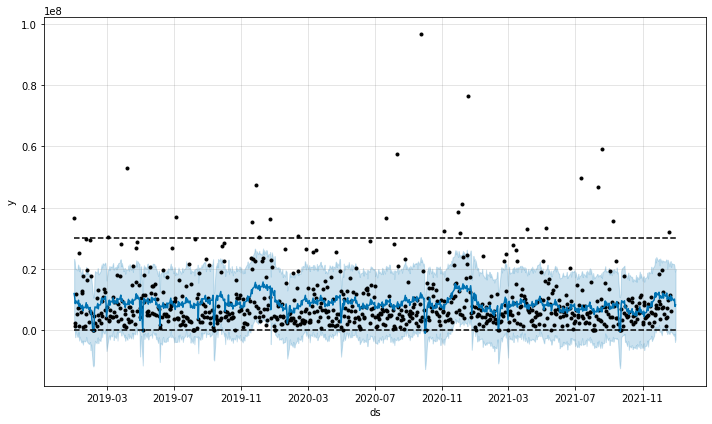

In [ ]:
fig = m.plot(m.predict(future))

In [ ]:
r2 = round(r2_score(df_1160["y"], preds), 3)
mse = round(mean_squared_error(df_1160["y"], preds), 3)
mae = round(mean_absolute_error(df_1160["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.07
MSE:  76033516147147.16
MAE:  5594899.148


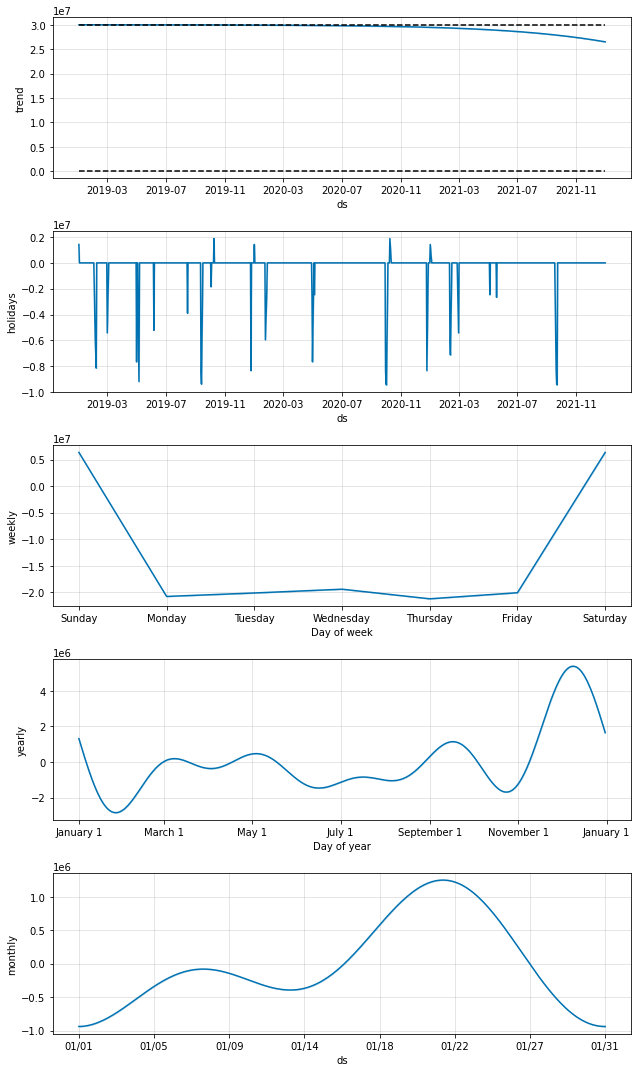

In [ ]:
fig = m.plot_components(forecast)

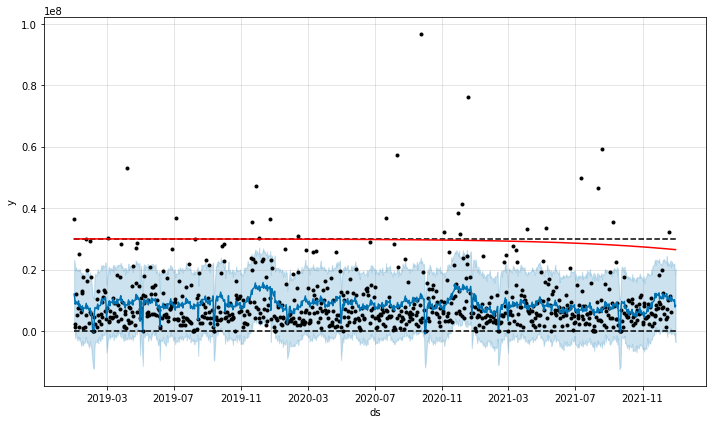

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds       yhat  yhat_lower  yhat_upper
775 2021-12-21 10,651,072    -269,565  22,318,096
776 2021-12-22 11,416,301     945,345  23,004,930
777 2021-12-23  9,671,513  -1,062,325  20,714,449
778 2021-12-24 10,851,778    -719,682  22,657,334
779 2021-12-27  9,727,845    -533,269  21,319,705
780 2021-12-28  9,994,686  -1,308,881  21,826,914
781 2021-12-29 10,203,052    -853,331  21,923,353
782 2021-12-30  7,799,218  -2,743,736  18,155,084
783 2021-12-31  8,296,057  -3,604,528  20,168,602


In [ ]:
final_1160 = forecast[['ds', 'yhat']]
final_1160['yhat_1160'] = final_1160['yhat']
final_1160 = final_1160[['ds', 'yhat_1160']]
final_1160.head()

,ds,yhat_1160
0,2019-01-01,"12,005,962"
1,2019-01-02,"10,864,804"
2,2019-01-03,"8,736,150"
3,2019-01-04,"9,663,633"
4,2019-01-07,"8,677,055"


In [ ]:
#Pusan
df_1170 = df[['date','1170']]
df_1170['ds'] = pd.to_datetime(df_1170['date'])
df_1170['y'] = df_1170['1170']
df_1170 = df_1170.loc[:,['ds', 'y']]
df_1170.head()

,ds,y
0,2019-01-01,413605
1,2019-01-02,376392
2,2019-01-03,3091350
3,2019-01-04,1121545
4,2019-01-05,22642


In [ ]:
df_1170['ds'] = pd.to_datetime(df_1170['ds'])
df_1170 = df_1170[df_1170['ds'].dt.dayofweek < 5]
df_1170['date_index'] = df_1170['ds']
df_1170 = df_1170.set_index('date_index')
df_1170['cap'] = 30000000
df_1170['floor'] = 0
df_1170.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,413605,30000000,0
2019-01-02,2019-01-02,376392,30000000,0
2019-01-03,2019-01-03,3091350,30000000,0
2019-01-04,2019-01-04,1121545,30000000,0
2019-01-07,2019-01-07,417019,30000000,0
2019-01-08,2019-01-08,2138914,30000000,0
2019-01-09,2019-01-09,1631129,30000000,0
2019-01-10,2019-01-10,1037626,30000000,0
2019-01-11,2019-01-11,26471675,30000000,0


In [ ]:
from datetime import datetime
df_1170 = df_1170[datetime(2019, 1, 1):datetime(2021, 12, 22)]

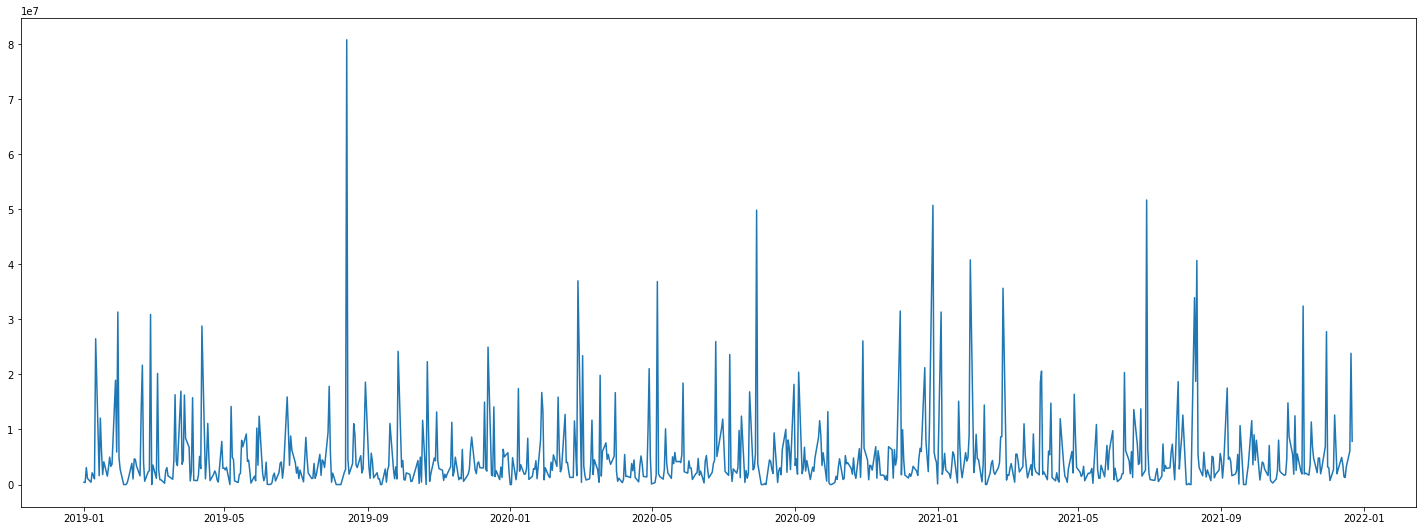

In [ ]:
plt.figure(figsize = (25, 9))
plt.plot(df_1170.index,df_1170.y)
plt.show()

In [ ]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1170)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 50000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"2,519,416",50000000,0,"-3,240,232","14,495,843","2,519,416","2,519,416",0,0,...,"4,086,667","4,086,667","4,086,667","789,532","789,532","789,532",0,0,0,"5,767,350"
775,2021-12-21,"2,526,700",50000000,0,"-1,553,679","16,025,584","2,526,700","2,526,700",0,0,...,"4,944,195","4,944,195","4,944,195","829,342","829,342","829,342",0,0,0,"6,674,386"
776,2021-12-22,"2,534,003",50000000,0,"-481,900","17,236,827","2,534,003","2,534,003",0,0,...,"6,587,246","6,587,246","6,587,246","867,749","867,749","867,749",0,0,0,"8,628,826"
777,2021-12-23,"2,541,326",50000000,0,"-2,966,093","14,891,888","2,541,326","2,541,326",0,0,...,"3,884,488","3,884,488","3,884,488","904,654","904,654","904,654",0,0,0,"6,496,575"
778,2021-12-24,"2,548,670",50000000,0,"-1,198,655","16,565,535","2,548,670","2,548,670",0,0,...,"4,751,165","4,751,165","4,751,165","939,965","939,965","939,965",0,0,0,"8,145,110"
779,2021-12-27,"2,570,821",50000000,0,"1,738,341","19,073,945","2,570,821","2,570,821",0,0,...,"4,086,667","4,086,667","4,086,667","1,035,506","1,035,506","1,035,506",0,0,0,"10,117,490"
780,2021-12-28,"2,578,245",50000000,0,"2,939,594","19,534,113","2,578,245","2,578,245",0,0,...,"4,944,195","4,944,195","4,944,195","1,063,655","1,063,655","1,063,655",0,0,0,"11,567,555"
781,2021-12-29,"2,585,689",50000000,0,"4,867,196","22,288,696","2,585,689","2,585,689",0,0,...,"6,587,246","6,587,246","6,587,246","1,089,859","1,089,859","1,089,859",0,0,0,"13,502,843"
782,2021-12-30,"2,593,154",50000000,0,"1,590,229","19,319,388","2,593,154","2,593,154",0,0,...,"3,884,488","3,884,488","3,884,488","1,114,077","1,114,077","1,114,077",0,0,0,"10,751,597"
783,2021-12-31,"2,600,639",50000000,0,"2,353,544","19,547,723","2,600,639","2,600,639",0,0,...,"4,751,165","4,751,165","4,751,165","1,136,274","1,136,274","1,136,274",0,0,0,"11,236,735"


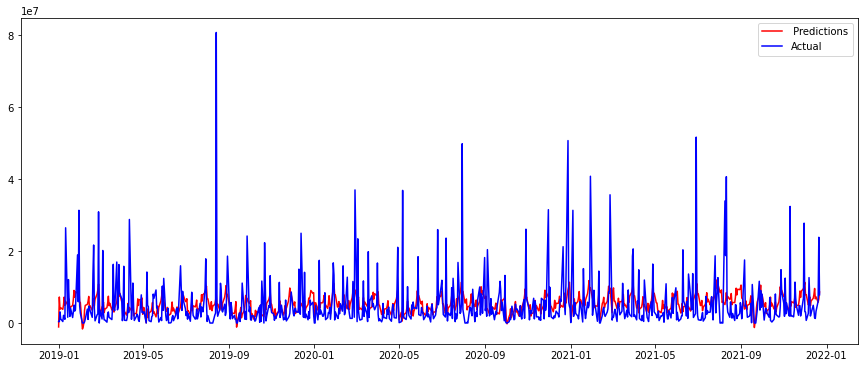

In [ ]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1170.index,preds,color='red',label=' Predictions')
plt.plot(df_1170.index,df_1170.y,color='blue',label='Actual')
plt.legend()
plt.show()

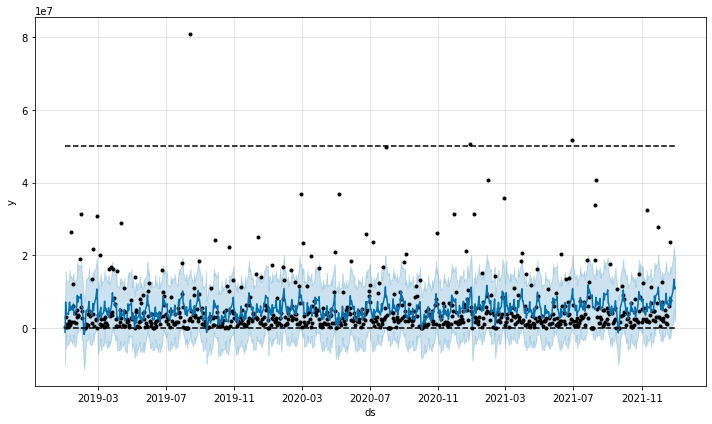

In [ ]:
fig = m.plot(m.predict(future))

In [ ]:
r2 = round(r2_score(df_1170["y"], preds), 3)
mse = round(mean_squared_error(df_1170["y"], preds), 3)
mae = round(mean_absolute_error(df_1170["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.09
MSE:  46584164290740.72
MAE:  4067227.289


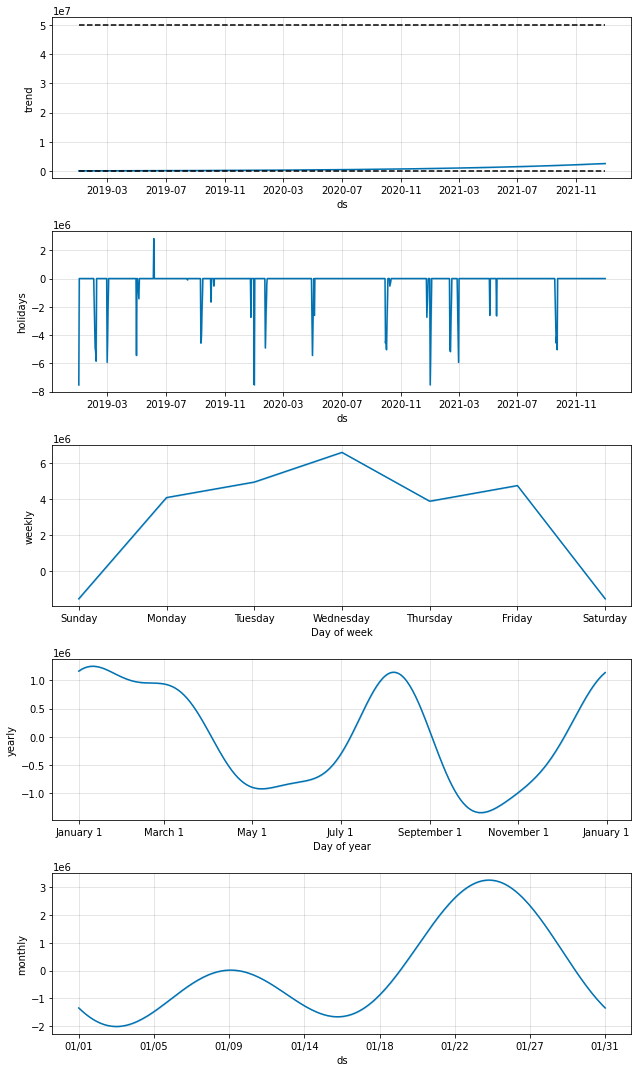

In [ ]:
fig = m.plot_components(forecast)

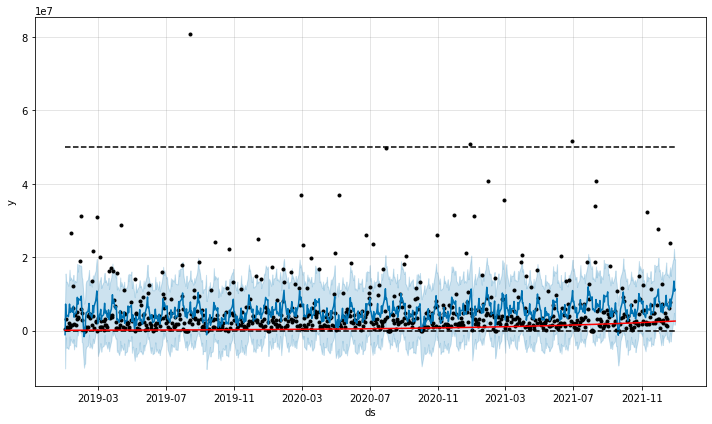

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds       yhat  yhat_lower  yhat_upper
775 2021-12-21  6,674,386  -1,553,679  16,025,584
776 2021-12-22  8,628,826    -481,900  17,236,827
777 2021-12-23  6,496,575  -2,966,093  14,891,888
778 2021-12-24  8,145,110  -1,198,655  16,565,535
779 2021-12-27 10,117,490   1,738,341  19,073,945
780 2021-12-28 11,567,555   2,939,594  19,534,113
781 2021-12-29 13,502,843   4,867,196  22,288,696
782 2021-12-30 10,751,597   1,590,229  19,319,388
783 2021-12-31 11,236,735   2,353,544  19,547,723


In [ ]:
final_1170 = forecast[['ds', 'yhat']]
final_1170['yhat_1170'] = final_1170['yhat']
final_1170 = final_1170[['ds', 'yhat_1170']]
final_1170.head()

,ds,yhat_1170
0,2019-01-01,"-1,089,121"
1,2019-01-02,"7,229,429"
2,2019-01-03,"3,828,448"
3,2019-01-04,"4,238,674"
4,2019-01-07,"3,798,642"


In [ ]:
#Noksan
df_1180 = df[['date','1180']]
df_1180['ds'] = pd.to_datetime(df_1180['date'])
df_1180['y'] = df_1180['1180']
df_1180 = df_1180.loc[:,['ds', 'y']]
df_1180.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,0
2,2019-01-03,213875
3,2019-01-04,147575
4,2019-01-05,245600


In [ ]:
df_1180['ds'] = pd.to_datetime(df_1180['ds'])
df_1180 = df_1180[df_1180['ds'].dt.dayofweek < 5]
df_1180['date_index'] = df_1180['ds']
df_1180 = df_1180.set_index('date_index')
df_1180['cap'] = 30000000
df_1180['floor'] = 0
df_1180.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,0,30000000,0
2019-01-03,2019-01-03,213875,30000000,0
2019-01-04,2019-01-04,147575,30000000,0
2019-01-07,2019-01-07,2700,30000000,0
2019-01-08,2019-01-08,0,30000000,0
2019-01-09,2019-01-09,126750,30000000,0
2019-01-10,2019-01-10,8990,30000000,0
2019-01-11,2019-01-11,33160,30000000,0


In [ ]:
from datetime import datetime
df_1180 = df_1180[datetime(2019, 1, 1):datetime(2021, 12, 22)]

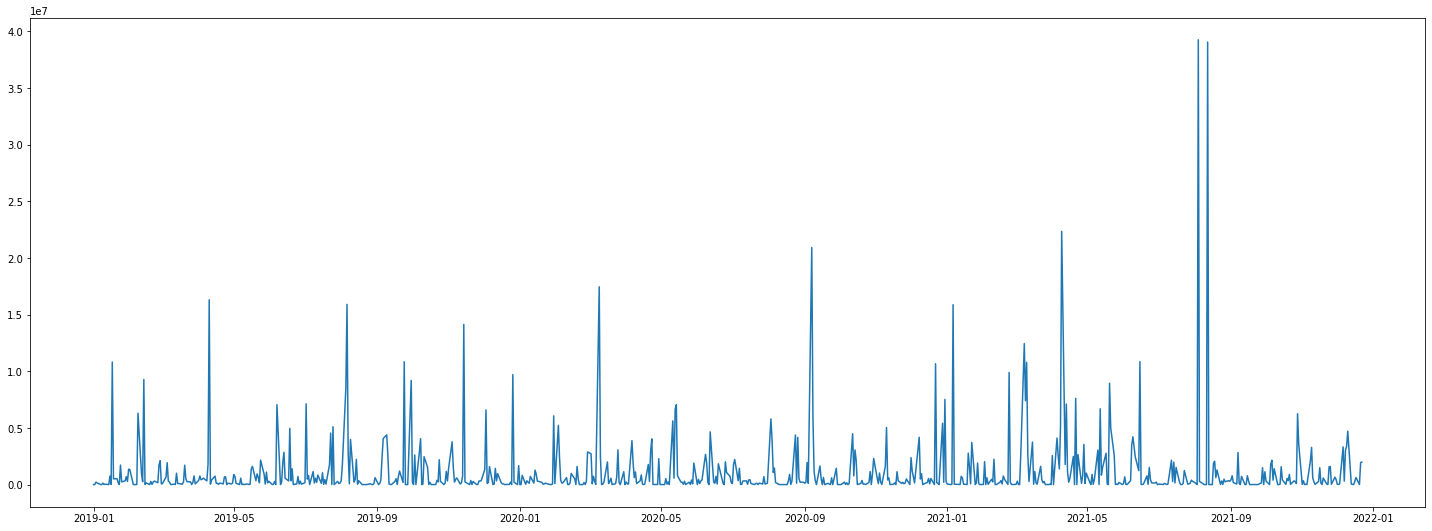

In [ ]:
plt.figure(figsize = (25, 9))
plt.plot(df_1180.index,df_1180.y)
plt.show()

In [ ]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1180)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"658,950",25000000,0,"-3,023,285","4,850,126","658,950","658,950",0,0,...,"909,605","909,605","909,605","-83,015","-83,015","-83,015",0,0,0,"965,234"
775,2021-12-21,"660,211",25000000,0,"-2,814,107","4,997,107","660,211","660,211",0,0,...,"942,930","942,930","942,930","-61,603","-61,603","-61,603",0,0,0,"1,094,531"
776,2021-12-22,"661,476",25000000,0,"-2,486,959","4,993,756","661,476","661,476",0,0,...,"1,077,587","1,077,587","1,077,587","-40,963","-40,963","-40,963",0,0,0,"1,330,907"
777,2021-12-23,"662,742",25000000,0,"-2,885,230","4,920,087","662,742","662,742",0,0,...,"909,661","909,661","909,661","-21,218","-21,218","-21,218",0,0,0,"1,247,926"
778,2021-12-24,"664,011",25000000,0,"-2,964,729","4,732,422","664,011","664,011",0,0,...,"554,206","554,206","554,206","-2,487","-2,487","-2,487",0,0,0,"944,064"
779,2021-12-27,"667,831",25000000,0,"-2,657,720","4,953,935","667,831","667,831",0,0,...,"909,605","909,605","909,605","46,560","46,560","46,560",0,0,0,"1,228,574"
780,2021-12-28,"669,109",25000000,0,"-2,578,395","4,871,139","669,109","669,109",0,0,...,"942,930","942,930","942,930","60,216","60,216","60,216",0,0,0,"1,202,146"
781,2021-12-29,"670,390",25000000,0,"-2,492,368","5,032,229","670,390","670,390",0,0,...,"1,077,587","1,077,587","1,077,587","72,396","72,396","72,396",0,0,0,"1,294,684"
782,2021-12-30,"671,673",25000000,0,"-2,545,566","5,270,273","671,673","671,673",0,0,...,"909,661","909,661","909,661","83,037","83,037","83,037",0,0,0,"1,125,279"
783,2021-12-31,"672,958",25000000,0,"-2,938,568","4,316,333","672,958","672,958",0,0,...,"554,206","554,206","554,206","92,088","92,088","92,088",0,0,0,"826,887"


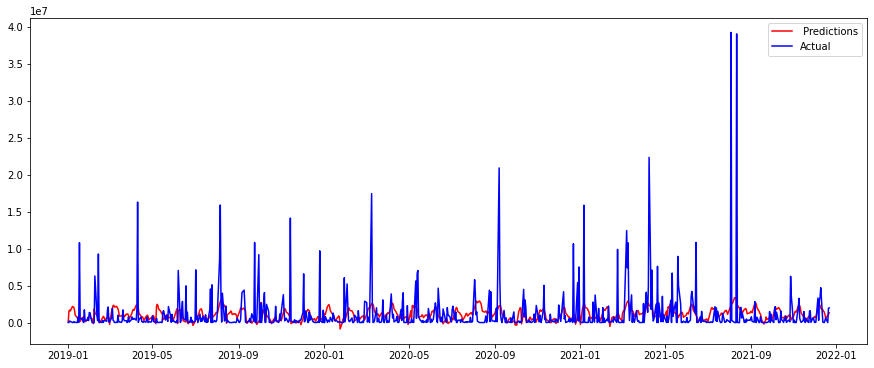

In [ ]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1180.index,preds,color='red',label=' Predictions')
plt.plot(df_1180.index,df_1180.y,color='blue',label='Actual')
plt.legend()
plt.show()

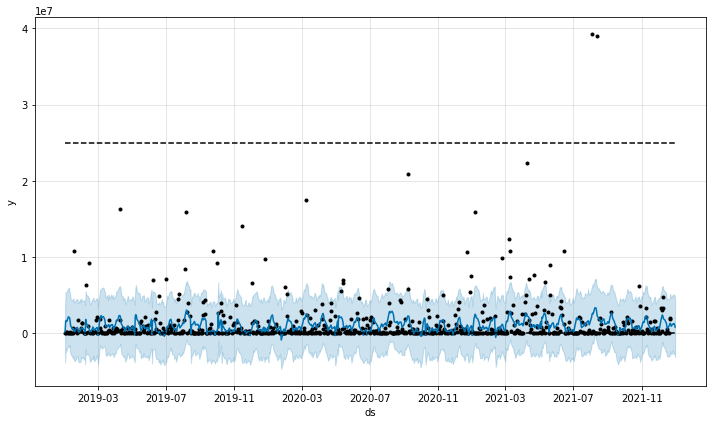

In [ ]:
fig = m.plot(m.predict(future))

In [ ]:
r2 = round(r2_score(df_1180["y"], preds), 3)
mse = round(mean_squared_error(df_1180["y"], preds), 3)
mae = round(mean_absolute_error(df_1180["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.057
MSE:  8857280934589.37
MAE:  1391491.013


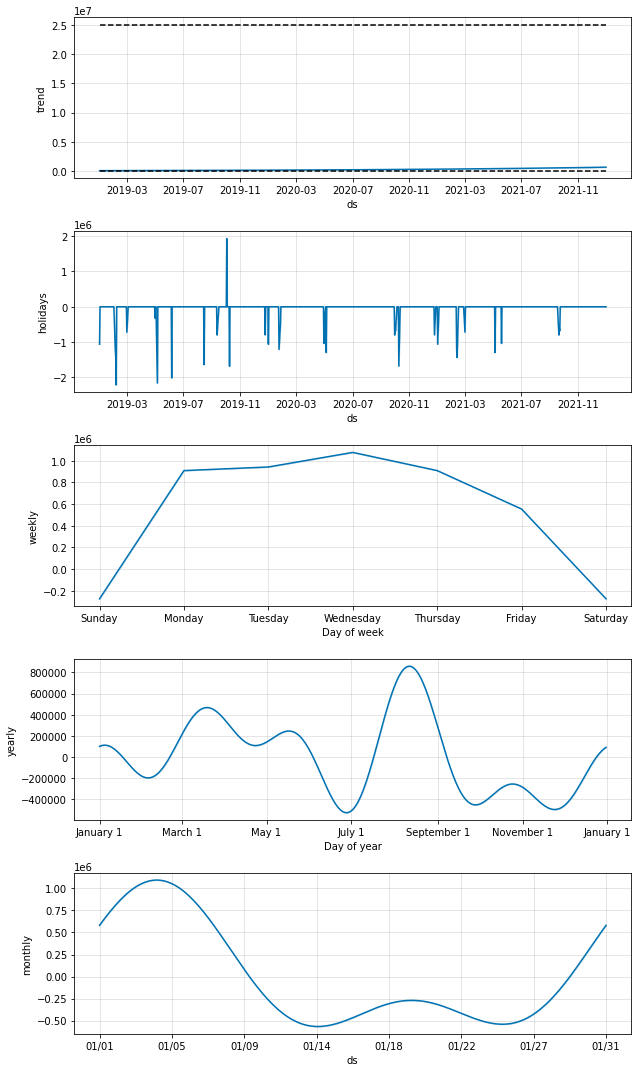

In [ ]:
fig = m.plot_components(forecast)

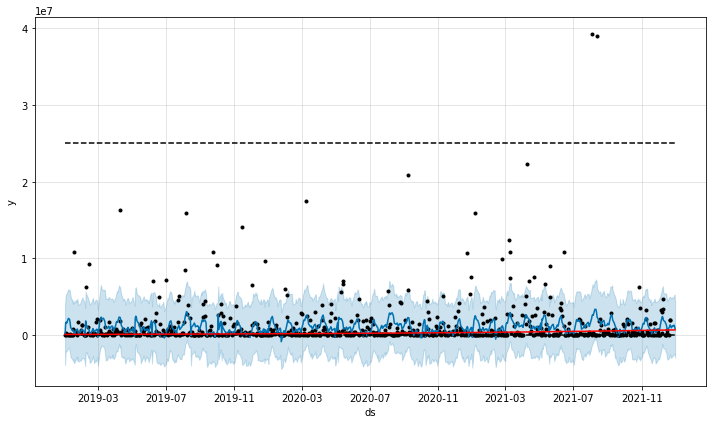

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 1,094,531  -2,814,107   4,997,107
776 2021-12-22 1,330,907  -2,486,959   4,993,756
777 2021-12-23 1,247,926  -2,885,230   4,920,087
778 2021-12-24   944,064  -2,964,729   4,732,422
779 2021-12-27 1,228,574  -2,657,720   4,953,935
780 2021-12-28 1,202,146  -2,578,395   4,871,139
781 2021-12-29 1,294,684  -2,492,368   5,032,229
782 2021-12-30 1,125,279  -2,545,566   5,270,273
783 2021-12-31   826,887  -2,938,568   4,316,333


In [ ]:
final_1180 = forecast[['ds', 'yhat']]
final_1180['yhat_1180'] = final_1180['yhat']
final_1180 = final_1180[['ds', 'yhat_1180']]
final_1180.head()

,ds,yhat_1180
0,2019-01-01,"103,810"
1,2019-01-02,"1,574,667"
2,2019-01-03,"1,680,277"
3,2019-01-04,"1,564,919"
4,2019-01-07,"2,180,438"


In [ ]:
final_1110['date_index'] = final_1110['ds']
final_1110 = final_1110.set_index('date_index')

final_1120['date_index'] = final_1120['ds']
final_1120 = final_1120.set_index('date_index')

final_1140['date_index'] = final_1140['ds']
final_1140 = final_1140.set_index('date_index')

final_1150['date_index'] = final_1150['ds']
final_1150 = final_1150.set_index('date_index')

final_1160['date_index'] = final_1160['ds']
final_1160 = final_1160.set_index('date_index')

final_1170['date_index'] = final_1170['ds']
final_1170 = final_1170.set_index('date_index')

final_1180['date_index'] = final_1180['ds']
final_1180 = final_1180.set_index('date_index')

In [ ]:
final_1110.dtypes

ds           datetime64[ns]
yhat_1110           float64
dtype: object

In [ ]:
final_total = pd.merge(final_1110, final_1120)
final_total = pd.merge(final_total, final_1140)
final_total = pd.merge(final_total, final_1150)
final_total = pd.merge(final_total, final_1160)
final_total = pd.merge(final_total, final_1170)
final_total = pd.merge(final_total, final_1180)
final_total.tail()

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180
779,2021-12-27,"9,208,979","7,609,742","4,822,025","412,017","9,727,845","10,117,490","1,228,574"
780,2021-12-28,"8,990,868","8,326,674","4,742,519","368,350","9,994,686","11,567,555","1,202,146"
781,2021-12-29,"5,275,927","7,200,156","4,533,306","1,237,770","10,203,052","13,502,843","1,294,684"
782,2021-12-30,"5,909,777","7,640,593","4,795,117","607,207","7,799,218","10,751,597","1,125,279"
783,2021-12-31,"6,301,348","6,829,005","3,896,113","428,447","8,296,057","11,236,735","826,887"


In [ ]:
final_total['final_sum'] = final_total['yhat_1110'] + final_total['yhat_1120'] + final_total['yhat_1140'] + final_total['yhat_1150'] + final_total['yhat_1160'] +final_total['yhat_1170'] + final_total['yhat_1180']

In [ ]:
final_total.tail(7)

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180,final_sum
777,2021-12-23,"8,910,907","8,566,611","5,106,495","313,273","9,671,513","6,496,575","1,247,926","40,313,301"
778,2021-12-24,"9,088,726","8,066,505","4,382,439","160,811","10,851,778","8,145,110","944,064","41,639,432"
779,2021-12-27,"9,208,979","7,609,742","4,822,025","412,017","9,727,845","10,117,490","1,228,574","43,126,671"
780,2021-12-28,"8,990,868","8,326,674","4,742,519","368,350","9,994,686","11,567,555","1,202,146","45,192,797"
781,2021-12-29,"5,275,927","7,200,156","4,533,306","1,237,770","10,203,052","13,502,843","1,294,684","43,247,738"
782,2021-12-30,"5,909,777","7,640,593","4,795,117","607,207","7,799,218","10,751,597","1,125,279","38,628,789"
783,2021-12-31,"6,301,348","6,829,005","3,896,113","428,447","8,296,057","11,236,735","826,887","37,814,590"
